In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image
from xml.dom import minidom
import csv
import torch
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder

In [3]:
import re
pattern = r"(\d+)\.jpg$"
img_numbers=[]

for dirname, _, filenames in os.walk('/kaggle/input/annotated-potholes-dataset/annotated-images'):
    for filename in filenames:
        match = re.search(pattern,filename,re.IGNORECASE)
        if match:
            number = match.group(1)
            img_numbers.append(number)

img_numbers.sort()

In [4]:
def extract_xml_contents(annot_directory, image_dir, file_dir):
        
        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates 
        xmin = file.getElementsByTagName('xmin')
        x1 = int(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = int(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = int(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = int(ymax[0].firstChild.data)

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data
        filename = os.path.join(file_dir,filename)

        return filename, width, height, x1,y1,x2,y2

### Dataset 1

In [5]:
import pandas as pd

# Function to convert XML files to CSV
def xml_to_csv(data_dir):

  # List containing all our attributes regarding each image
    xml_list = []

  # Loop over each of the image and its label
    for i in img_numbers:
        
        mat = f"img-{i}.xml"
        image_file = f"img-{i}.jpg"
      
      # Full mat path
        mat_path = os.path.join(data_dir, mat)

      # Full path Image
        img_path = os.path.join(data_dir, image_file)

      # Get Attributes for each image 
        value = extract_xml_contents(mat_path, img_path,data_dir)

      # Append the attributes to the mat_list
        xml_list.append(value)

  # Columns for Pandas DataFrame
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
    xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
    return xml_df

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df1 = xml_to_csv(data_dir="/kaggle/input/annotated-potholes-dataset/annotated-images")

# Saving the Pandas DataFrame as CSV File
labels_df1.to_csv(('dataset.csv'), index=None)

In [6]:
labels_df1

,filename,width,height,xmin,ymin,xmax,ymax


### Dataset 2

In [7]:
# Read the CSV file and rename the columns
labels_df2 = pd.read_csv("train/labels.csv")
labels_df2.columns = ['filename', 'LabelName', 'xmin', 'xmax', 'ymin', 'ymax']
labels_df2.drop("LabelName", axis=1, inplace=True)

# Add a new column with the image filename and path
labels_df2['filename'] = labels_df2['filename'].apply(lambda x: "train/images/" + x)

# Add new columns with the image height and width
heights, widths = [], []
for _, row in labels_df2.iterrows():
    height, width = cv2.imread(row['filename']).shape[:2]
    heights.append(height)
    widths.append(width)

labels_df2 = labels_df2.assign(height=heights, width=widths)

# Print the resulting DataFrame
labels_df2

,filename,xmin,xmax,ymin,ymax,height,width
0,train/images/1.jpg,0,131,140,263,720,720
1,train/images/1.jpg,168,487,279,449,720,720
2,train/images/1.jpg,1,144,34,109,720,720
3,train/images/2.jpg,57,952,271,505,600,1200
4,train/images/3.jpg,225,416,292,439,720,720
...,...,...,...,...,...,...,...
1366,train/images/672.jpg,0,182,274,370,484,726
1367,train/images/672.jpg,0,176,166,227,484,726
1368,train/images/673.jpg,121,444,114,188,387,620
1369,train/images/674.jpg,50,158,82,168,183,275


In [8]:
labels_df = pd.concat([labels_df1,labels_df2],axis=0)
labels_df

,filename,width,height,xmin,ymin,xmax,ymax
0,train/images/1.jpg,720,720,0,140,131,263
1,train/images/1.jpg,720,720,168,279,487,449
2,train/images/1.jpg,720,720,1,34,144,109
3,train/images/2.jpg,1200,600,57,271,952,505
4,train/images/3.jpg,720,720,225,292,416,439
...,...,...,...,...,...,...,...
1366,train/images/672.jpg,726,484,0,274,182,370
1367,train/images/672.jpg,726,484,0,166,176,227
1368,train/images/673.jpg,620,387,121,114,444,188
1369,train/images/674.jpg,275,183,50,82,158,168


In [9]:
DATA_DIR = "annotated-images/"

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
IMG_SIZE = 128
LR = 0.01
EPOCHS = 100
MODEL_NAME = "res2net50d.in1k"
NUM_COR = 4

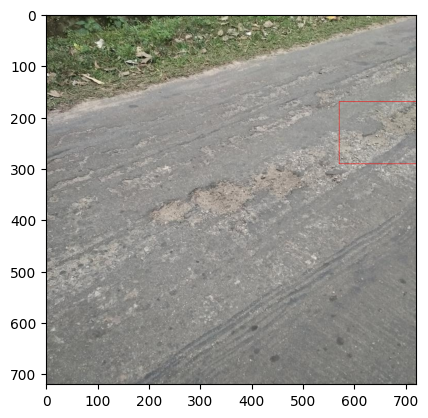

In [11]:
row = labels_df.iloc[12]

img = cv2.imread(row.filename)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0),1)

plt.imshow(bnd_box_img)

In [12]:
train_df, valid_df = train_test_split(labels_df,test_size=0.10,random_state=42)

In [13]:
import albumentations as A

In [14]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

In [15]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        xmin = row.xmin 
        ymin = row.ymin 
        xmax = row.xmax 
        ymax = row.ymax  
        bbox = [[xmin,ymin,xmax,ymax]]

        img_path = row.filename
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        if self.augs:
            data = self.augs(image = img, bboxes=bbox, class_labels = [None])
            img = data["image"]
           
            bbox = data["bboxes"][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [16]:
trainset = PotholeDataset(train_df,train_augs)
validset = PotholeDataset(valid_df,valid_augs)

In [17]:
len(validset)

138

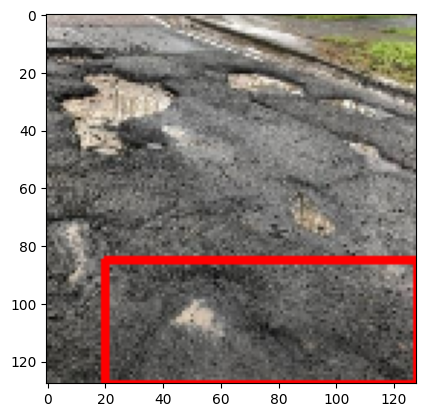

In [18]:
img, bbox = trainset[0]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

In [19]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validLoader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [20]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validLoader)))

Total no. batches in trainloader : 78
Total no. batches in validloader : 9


In [21]:
for images,bboxes in trainloader:
    break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 128, 128])
Shape of one batch bboxes : torch.Size([16, 4])


In [22]:
from torch import nn
import torchvision
import timm

In [23]:
class PotholeModel(nn.Module):
    def __init__(self) -> None:
        super(PotholeModel,self).__init__()

        self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)


    def forward(self,images,gt_bboxes=None):
        predBboxes = self.backbone(images)

        if gt_bboxes != None:
            loss1 = torchvision.ops.complete_box_iou_loss(predBboxes,gt_bboxes,reduction="sum")
            loss2 = nn.functional.smooth_l1_loss(predBboxes,gt_bboxes)
            return predBboxes,loss2 + loss1

        return predBboxes

In [24]:
model = PotholeModel()
model.to(DEVICE)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/res2net50d.in1k)
INFO:timm.models._hub:[timm/res2net50d.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


PotholeModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running

In [25]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

In [26]:
def train(model,dataLoader,optimizer):
    total_loss = 0
    model.train()

    for data in tqdm(dataLoader):
        images,gt_bboxes = data
        images,gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images,gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataLoader)

In [27]:
def eval(model,dataLoader):
    total_loss = 0
    model.eval()

    with torch.inference_mode():
        for data in tqdm(dataLoader):
            images,gt_bboxes = data
            images,gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images,gt_bboxes)

            total_loss += loss.item()

        return total_loss / len(dataLoader)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
import IProgress

In [30]:
best_valid_loss = np.Inf
EPOCHS = 2  # Set number of epochs to 20

for i in range(EPOCHS):
    train_loss = train(model, trainloader, optimizer)
    valid_loss = eval(model, validLoader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print("WEIGHTS SAVED!!")
        best_valid_loss = valid_loss

    print(f"Epoch : {i + 1}, train Loss : {train_loss:.4f}, valid loss : {valid_loss:.4f}")

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

WEIGHTS SAVED!!
Epoch : 1, train Loss : 61.9305, valid loss : 4536.2437


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

WEIGHTS SAVED!!
Epoch : 2, train Loss : 37.6917, valid loss : 305.3732


In [31]:
# Function to calculate perceived focal length
def calculate_perceived_focal_length(bbox):
    length = bbox[3] - bbox[1]
    width = bbox[2] - bbox[0]
    pixel_length = length  # Assuming length represents pixel length
    camera_distance = 90  # Fixed camera distance in centimeters
    return (pixel_length * camera_distance) / width




In [39]:
# Dimension Estimation
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
perceived_focal_lengths=[]
for images, gt_bboxes in validLoader:
    images = images.to(DEVICE)
    # Perform inference
    with torch.no_grad():
        pred_bboxes = model(images)
    # Calculate perceived focal length for each detected pothole
    for pred_bbox in pred_bboxes:
        perceived_focal_length = calculate_perceived_focal_length(pred_bbox)
        perceived_focal_lengths.append(perceived_focal_length)


In [40]:
# Calculate average perceived focal length
average_perceived_focal_length = torch.mean(torch.tensor(perceived_focal_lengths).cpu()).item()
print(f"Average Perceived Focal Length: {average_perceived_focal_length} cm")


Average Perceived Focal Length: 65.69315338134766 cm


In [2]:
def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

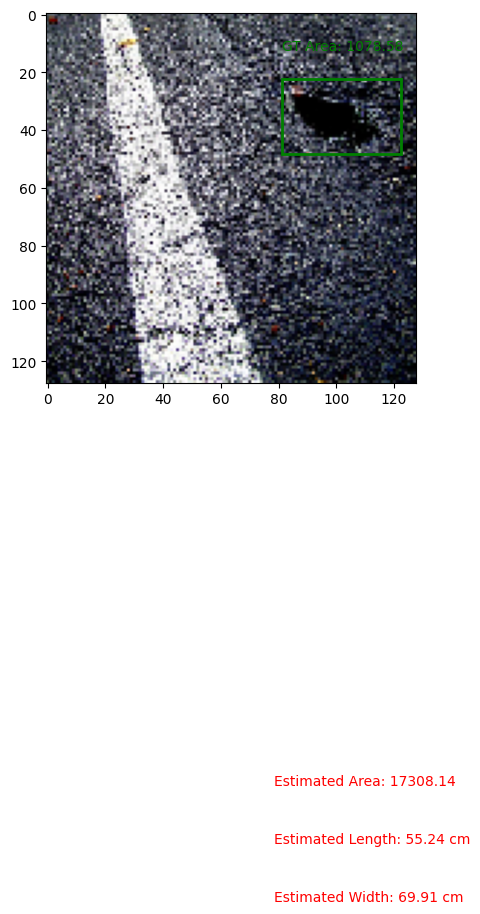

In [54]:
# Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Function to calculate dimension estimation
def calculate_dimensions(bbox):
    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.squeeze().tolist()

    # Calculate length and width of the bounding box
    length = ymax - ymin
    width = xmax - xmin

    # Calculate area of the pothole
    area = length * width

    # Estimate actual dimensions using the perceived focal length
    actual_length = (perceived_focal_length * length) / IMG_SIZE  # Assuming image size is used for scaling
    actual_width = (perceived_focal_length * width) / IMG_SIZE

    return actual_length, actual_width, area

# Function to compare plots with dimension estimation
def compare_plots_with_dimension(image, gt_bbox, out_bbox):
    # Perform dimension estimation
    actual_length, actual_width, area = calculate_dimensions(out_bbox)

    # Plot the image with bounding boxes and dimension estimation
    fig, ax = plt.subplots()
    ax.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())

    # Plot ground truth bounding box
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox
    gt_length = gt_ymax - gt_ymin
    gt_width = gt_xmax - gt_xmin
    gt_area = gt_length * gt_width
    ax.add_patch(plt.Rectangle((gt_xmin, gt_ymin), gt_width, gt_length, edgecolor='g', facecolor='none', linewidth=2))
    ax.text(gt_xmin, gt_ymin - 10, f'GT Area: {gt_area:.2f}', color='g', fontsize=10)

    # Plot detected bounding box
    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox.squeeze().tolist()
    out_length = out_ymax - out_ymin
    out_width = out_xmax - out_xmin
    ax.add_patch(plt.Rectangle((out_xmin, out_ymin), out_width, out_length, edgecolor='r', facecolor='none', linewidth=2))
    ax.text(out_xmin, out_ymax + 20, f'Estimated Area: {area:.2f}', color='r', fontsize=10)
    ax.text(out_xmin, out_ymax + 40, f'Estimated Length: {actual_length:.2f} cm', color='r', fontsize=10)
    ax.text(out_xmin, out_ymax + 60, f'Estimated Width: {actual_width:.2f} cm', color='r', fontsize=10)

    plt.show()

# Perform inference on a sample image and visualize with dimension estimation
image, gt_bbox = validset[5]
image = image.unsqueeze(0).to(DEVICE)
out_bbox = model(image)

compare_plots_with_dimension(image, gt_bbox,out_bbox)

tensor([[ 78.3337, 130.0547, 226.3372, 246.9989]])
tensor([ 81.3227,  22.1867, 122.5387,  48.3556])


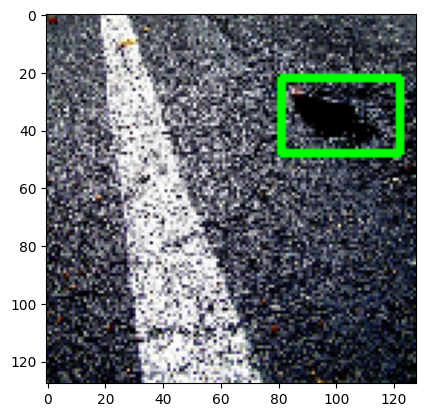

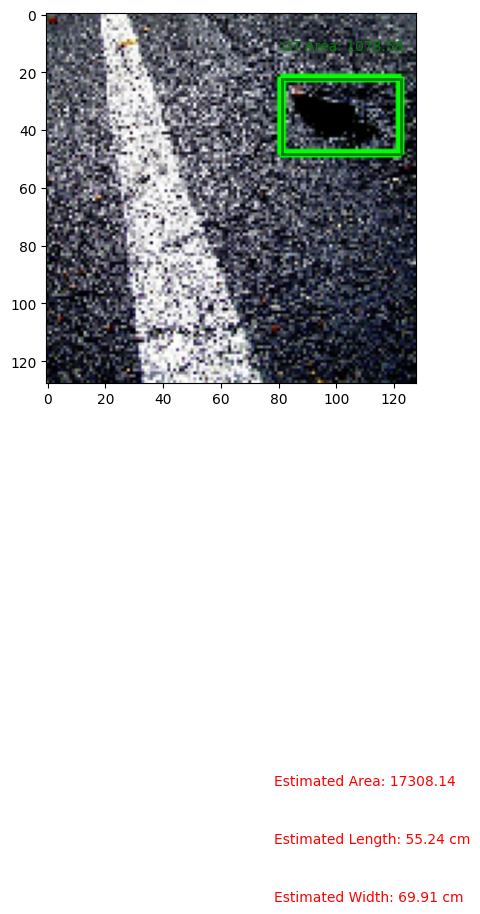

In [58]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[5]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)
    compare_plots_with_dimension(image,gt_bbox,out_bbox)

tensor([[ 253.6105,  460.6788, 1032.0540, 1056.0010]])
tensor([ 24.9000,  68.6464, 115.3000, 119.9063])


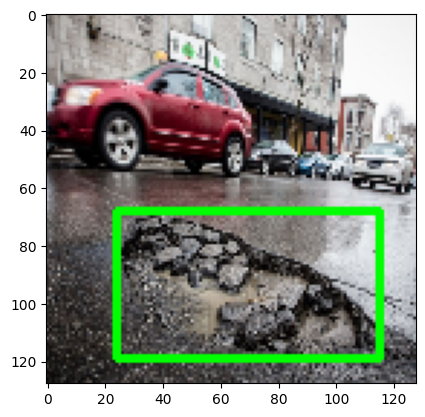

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[12]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

tensor([[ 80.3295, 129.3480, 214.4162, 235.2181]])
tensor([41.2444, 50.6667, 68.2667, 71.6444])


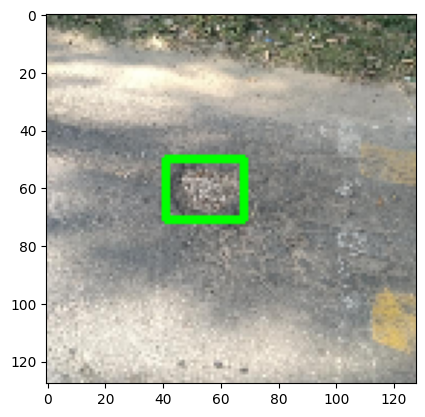

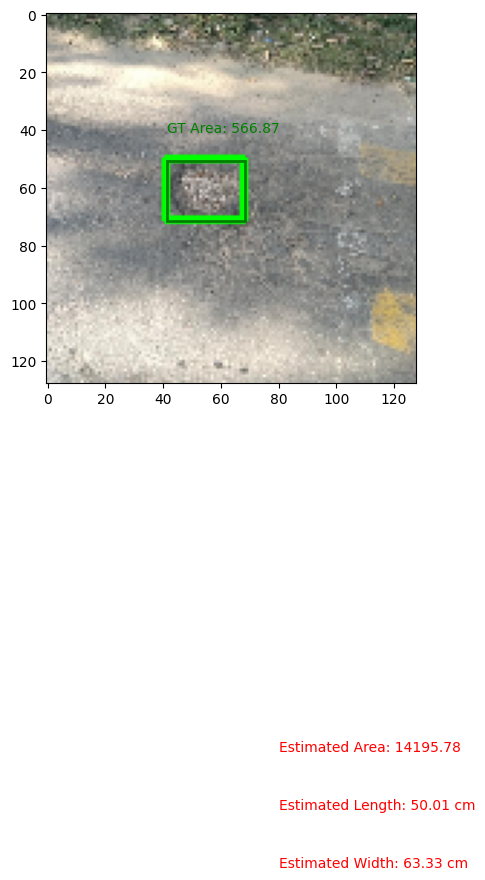

In [59]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[13]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)
    compare_plots_with_dimension(image,gt_bbox,out_bbox)

tensor([[38.9365, 46.3193, 91.1005, 83.2909]])
tensor([27.7333, 39.1111, 64.1778, 65.9556])


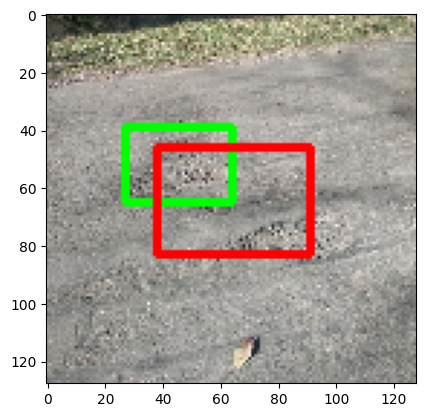

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[15]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

tensor([[39.3656, 47.5099, 94.3458, 87.5870]])
tensor([ 78.0488,  71.2533, 119.1144, 107.5200])


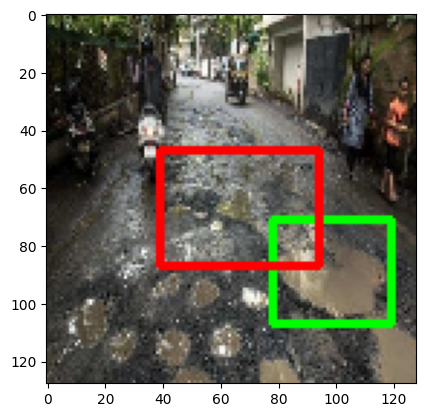

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[23]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

tensor([[ 425.2400,  787.1850, 1774.0182, 1817.8352]])
tensor([42.5600, 38.8267, 90.5600, 88.3200])


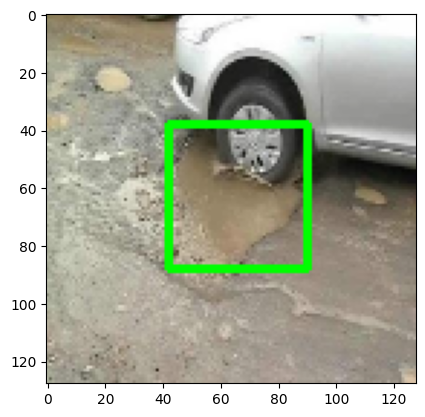

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[3]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)